In [2]:
import sqlite3
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

conn = sqlite3.connect('C:/Users/Siwoo/PycharmProjects/ValuatorV2/database/valuator.db')

In [3]:
param = {}  # a dict that stores all the parameter values
param["date_begin"] = datetime.datetime(2000, 1, 1)  # earliest of the whole data
param["val_split_point"] = datetime.datetime(2020, 1, 1)  # valid date begins with this date
param["date_end"] = datetime.datetime(2022, 1, 1)  # latest of the whole data

# preprocessing steps for x (financial statements)
param["TTM"] = False  # uses trailing twelve months average data instead of raw
param["adjust_price_w_CPI"] = False  # allows adjusting prices with CPI data
param["apply_asset_constraint"] = False  # allows applying the asset constraint (asset = equity + liability)
param[
    "apply_nonnegative_constraint"] = False  # deletes rows where their supposedly non-negative columns have negative column values
param["divide_by_total_assets"] = True  # divide the relevant columns with total assets to diminish multicolinearity
param["filter_by_volume"] = 1000

param["window_length"] = 120

In [7]:
df = pd.read_sql(f"""
SELECT * FROM bic
WHERE symbol in
        (SELECT symbol FROM profiles
        WHERE country = "US"
        AND isFund = 0
        AND isEtf = 0
        AND currency = "USD"
        AND (exchangeShortName = "NASDAQ" OR exchangeShortName = "NYSE"))
    AND symbol NOT LIKE '%W'
    AND fillingDate BETWEEN date('{param["date_begin"].strftime("%Y-%m-%d")}') AND date('{param["date_end"].strftime("%Y-%m-%d")}')
ORDER BY symbol, date ASC
""", con=conn)

macro_df = pd.read_sql("""
SELECT * FROM macro_US
""", con=conn)

treasury_df = pd.read_sql("""
SELECT * FROM treasury
""", con=conn)

In [8]:
cursor = conn.execute("""SELECT * FROM balance""")
balance_columns = [description[0] for description in cursor.description]

cursor = conn.execute("""SELECT * FROM income""")
income_columns = [description[0] for description in cursor.description]

cursor = conn.execute("""SELECT * FROM cashflow""")
cashflow_columns = [description[0] for description in cursor.description]

In [9]:
df['fillingDate'] = pd.to_datetime(df['fillingDate'])
df['date'] = pd.to_datetime(df['date'])
macro_df['date'] = pd.to_datetime(macro_df['date'])
CPI_base = macro_df[macro_df['date'] == param["val_split_point"]]['CPI'].values
macro_df['CPI'] = macro_df['CPI'] / CPI_base

In [10]:
df = df.merge(macro_df, how="left", on="date")
df = df.set_index(['symbol', 'date'])
df = df.drop(columns=['fillingDate', 'reportedCurrency'])

In [11]:
balance_ignored_features = ['goodwillAndIntangibleAssets',
                            'totalLiabilitiesAndStockholdersEquity',
                            'netDebt',
                            'cashAndShortTermInvestments']
income_ignored_features = ['grossProfitRatio',
                           'costAndExpenses',
                           'EBITDARatio',
                           'operatingIncomeRatio',
                           'incomeBeforeTaxRatio',
                           'netIncomeRatio',
                           'EPSDiluted',
                           'weightedAverageShsOut',
                           'interestIncome']
cashflow_ignored_features = []  # nothing yet
macro_ignored_features = ['realGDP', "consumerSentiment", "smoothedUSRecessionProbabilities"]

In [12]:
df = df.drop(
    columns=balance_ignored_features + income_ignored_features + cashflow_ignored_features + macro_ignored_features)
other_dropped_columns = []
for column in df.columns:
    if "other" in str(column).lower() or "1" in str(column).lower():
        other_dropped_columns.append(column)
df = df.drop(columns=other_dropped_columns)
print(df.columns)

Index(['deferredRevenue', 'commonStock', 'cashAndCashEquivalents',
       'minorityInterest', 'totalNonCurrentAssets', 'changeInWorkingCapital',
       'inventory', 'deferredTaxLiabilitiesNonCurrent', 'freeCashFlow',
       'accountsReceivables', 'shortTermDebt', 'intangibleAssets',
       'capitalLeaseObligations', 'acquisitionsNet',
       'deferrredTaxLiabilitiesNonCurrent', 'goodwill',
       'netCashUsedForInvestingActivites', 'preferredStock', 'grossProfit',
       'taxAssets', 'capitalExpenditure', 'accountPayables',
       'totalCurrentLiabilities', 'cashAtEndOfPeriod',
       'totalStockholdersEquity', 'operatingIncome', 'totalDebt',
       'netCashProvidedByOperatingActivites', 'netChangeInCash', 'EBITDA',
       'revenue', 'salesMaturitiesOfInvestments', 'deferredRevenueNonCurrent',
       'totalLiabilities', 'retainedEarnings', 'stockBasedCompensation',
       'longTermInvestments', 'shortTermInvestments', 'commonStockRepurchased',
       'purchasesOfInvestments', 'totalCur

In [13]:
if param["adjust_price_w_CPI"]:
    df['federalFunds'] = df['federalFunds'] * df['CPI']
    df = df.divide(df['CPI'], axis=0)
df = df.drop(columns='CPI')

In [14]:
def reorder_dataframe(df, column_order):
    """
    Reorders a DataFrame based on a given list of column names.

    :param df: pandas DataFrame
    :param column_order: List of column names to order the DataFrame by
    :return: Reordered DataFrame
    """
    # Remove duplicates while preserving order
    seen = set()
    unique_column_order = [col for col in column_order if col not in seen and not seen.add(col)]

    # Filter out columns that are not in the DataFrame
    valid_columns = [col for col in unique_column_order if col in df.columns]

    extra_columns = [col for col in df.columns if col not in valid_columns]

    # Reorder the DataFrame
    reordered_df = df[valid_columns + extra_columns]

    return reordered_df

In [15]:
df = reorder_dataframe(df, balance_columns + income_columns + cashflow_columns)
df.index = df.index.set_levels([df.index.levels[0], pd.to_datetime(df.index.levels[1])])

In [17]:
close = pd.read_sql(f"""
SELECT date, symbol, close
FROM cv
WHERE symbol in (SELECT symbol FROM profiles
    WHERE country = "US"
    AND isFund = 0
    AND isEtf = 0
    AND currency = "USD"
    AND (exchangeShortName = "NASDAQ" OR exchangeShortName = "NYSE"))
    AND date BETWEEN date('{param["date_begin"].strftime("%Y-%m-%d")}') AND date('{param["date_end"].strftime("%Y-%m-%d")}')
""", con=conn, index_col=["symbol", "date"])

spy = pd.read_sql(f"""
SELECT date, symbol, close
FROM cv
WHERE symbol = "SPY" AND date BETWEEN date('{param["date_begin"].strftime("%Y-%m-%d")}') AND date('{param["date_end"].strftime("%Y-%m-%d")}')
""", con=conn, index_col=["symbol", "date"])

In [18]:
close = close['close'].unstack(level=0)
spy = spy["close"].unstack(level=0)
close_prices = pd.merge(close, spy, "left", on='date')

In [19]:
close_prices[close_prices <= 0] = pd.NA
close_prices = close_prices.dropna(how='all', axis=1)  # now drop all symbols that have no values at all
close_prices = np.log(close_prices)  # apply log to every value
close_prices = close_prices.diff()  # calculate difference

In [20]:
market_return = close_prices['SPY']
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=param["window_length"])
close_cov = close_prices.rolling(window=90).cov(market_return)
market_var = market_return.rolling(window=90).var()
market_avg_return = market_return.rolling(window=90).mean()
close_beta = close_cov.div(market_var, axis=0)

In [21]:
calc_df = close_beta.merge(treasury_df[['date', 'BC_10YEAR']], "inner", on="date")
Rf = calc_df[['date', 'BC_10YEAR']].set_index('date')['BC_10YEAR'] / 100
Rf = Rf.rolling(window=90).mean()
beta_times_diff = close_beta.multiply((market_avg_return * 365 - Rf), axis=0)

equity_cost = beta_times_diff.add(Rf, axis=0)
equity_cost.index = pd.to_datetime(equity_cost.index)
equity_cost = equity_cost.stack()
equity_cost.name = 'equity_cost'

In [22]:
df = df.merge(equity_cost, how='inner', left_index=True, right_on=['symbol', 'date'])

In [96]:
tax_rate = df['incomeTaxExpense'] / df['incomeBeforeTax']
df['debt_cost'] = df['interestExpense'] / (df['totalDebt'] * (1 - tax_rate))
df['debt_ratio'] = df['totalDebt'] / (df['totalDebt'] + df['totalStockholdersEquity'])
df['equity_ratio'] = df['totalStockholdersEquity'] / (df['totalDebt'] + df['totalStockholdersEquity'])
df['equity_cost'] = 0.05
df['WACC'] = df['equity_cost'] * df['equity_ratio'] + df['debt_cost'] * df['debt_ratio']
df['WACC'] = 0.05

In [97]:
df_DCF = df[['freeCashFlow', 'WACC']].copy()
df_WACC = (df_DCF['WACC'] + 1) ** 0.25
df_DCF['WACC_ready'] = df_WACC.groupby(level=1).cumprod()

In [98]:
df_DCF['DCF'] = df_DCF['freeCashFlow'] / df_DCF['WACC_ready']
df_DCF['DCF_sum'] = df_DCF['DCF'].iloc[::-1].groupby(level=1).cumsum()

In [99]:
df_DCF['true_DCF'] = df_DCF['DCF_sum'] * df_DCF['WACC_ready']

In [100]:
df_DCF['true_DCF_price'] = df_DCF['true_DCF'] / df['weightedAverageShsOutDil']

In [101]:
close.index = pd.to_datetime(close.index)
close_stacked = close.stack()
close_stacked.name = "close"
df_DCF.index = df_DCF.index.set_levels([pd.to_datetime(df_DCF.index.levels[0]), df_DCF.index.levels[1]])
df_DCF = df_DCF.merge(close_stacked, how='inner', left_index=True, right_index=True)

Randomly selected symbol: VFC
Data for the selected symbol:


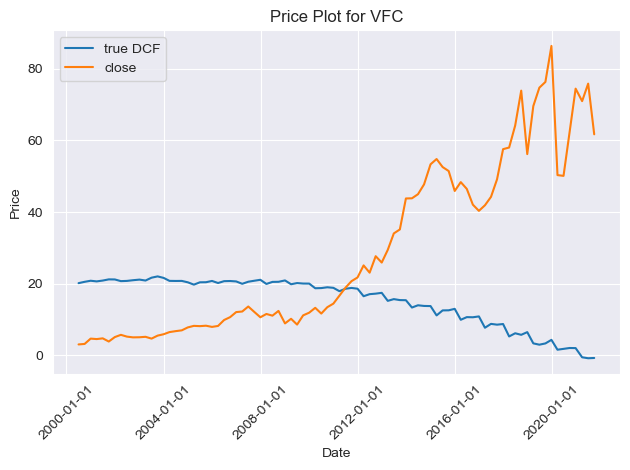

In [108]:
import matplotlib.dates as mdates

unique_symbols = df[df['weightedAverageShsOutDil'] > 100000000].index.get_level_values('symbol').unique()

# Step 2: Randomly select one symbol
random_symbol = np.random.choice(unique_symbols)
# Step 3: Filter the DataFrame for the randomly selected symbol
selected_df = df_DCF.xs(random_symbol, level='symbol')

# Output the randomly selected symbol and its corresponding data
print("Randomly selected symbol:", random_symbol)
print("Data for the selected symbol:")
fig, ax = plt.subplots()
ax.plot(selected_df.index, selected_df['true_DCF_price'])
ax.plot(selected_df.index, selected_df['close'])
# Formatting the date display on the x-axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Adding labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(['true DCF', 'close'])
ax.set_title(f'Price Plot for {random_symbol}')

# Rotate date labels for better visibility
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

# Display the plot
plt.show()